# Model Creation

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine
import sqlite3
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [89]:
con = sqlite3.connect("../database/PreprocessData.db")
data = pd.read_sql_query("SELECT * FROM hospitalData", con)

In [90]:
data

,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_id,icu_stay_type,icu_type,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,hospital_death
0,29.0,40.898275,0,Asian,F,164.0,Accident & Emergency,413,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0
1,78.0,24.218196,1,Caucasian,F,157.4,Operating Room / Recovery,512,admit,CCU-CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
2,54.0,45.680937,0,Caucasian,M,180.3,Accident & Emergency,543,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0
3,NaN,28.690874,0,African American,M,177.8,Accident & Emergency,504,admit,SICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,0
4,82.0,27.297959,0,Caucasian,F,175.0,Floor,413,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83715,68.0,27.140871,0,Caucasian,M,177.8,Accident & Emergency,498,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic,1
83716,59.0,21.290656,0,Caucasian,M,172.7,Accident & Emergency,678,admit,MICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,1
83717,71.0,31.727860,0,Hispanic,M,175.3,Floor,290,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,1
83718,70.0,47.223669,0,Caucasian,F,162.5,Floor,252,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,1


C:\Users\debor\AppData\Local\Temp\ipykernel_2820\760346063.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()['hospital_death'].sort_values(ascending=True).plot(kind="bar")


<AxesSubplot: >

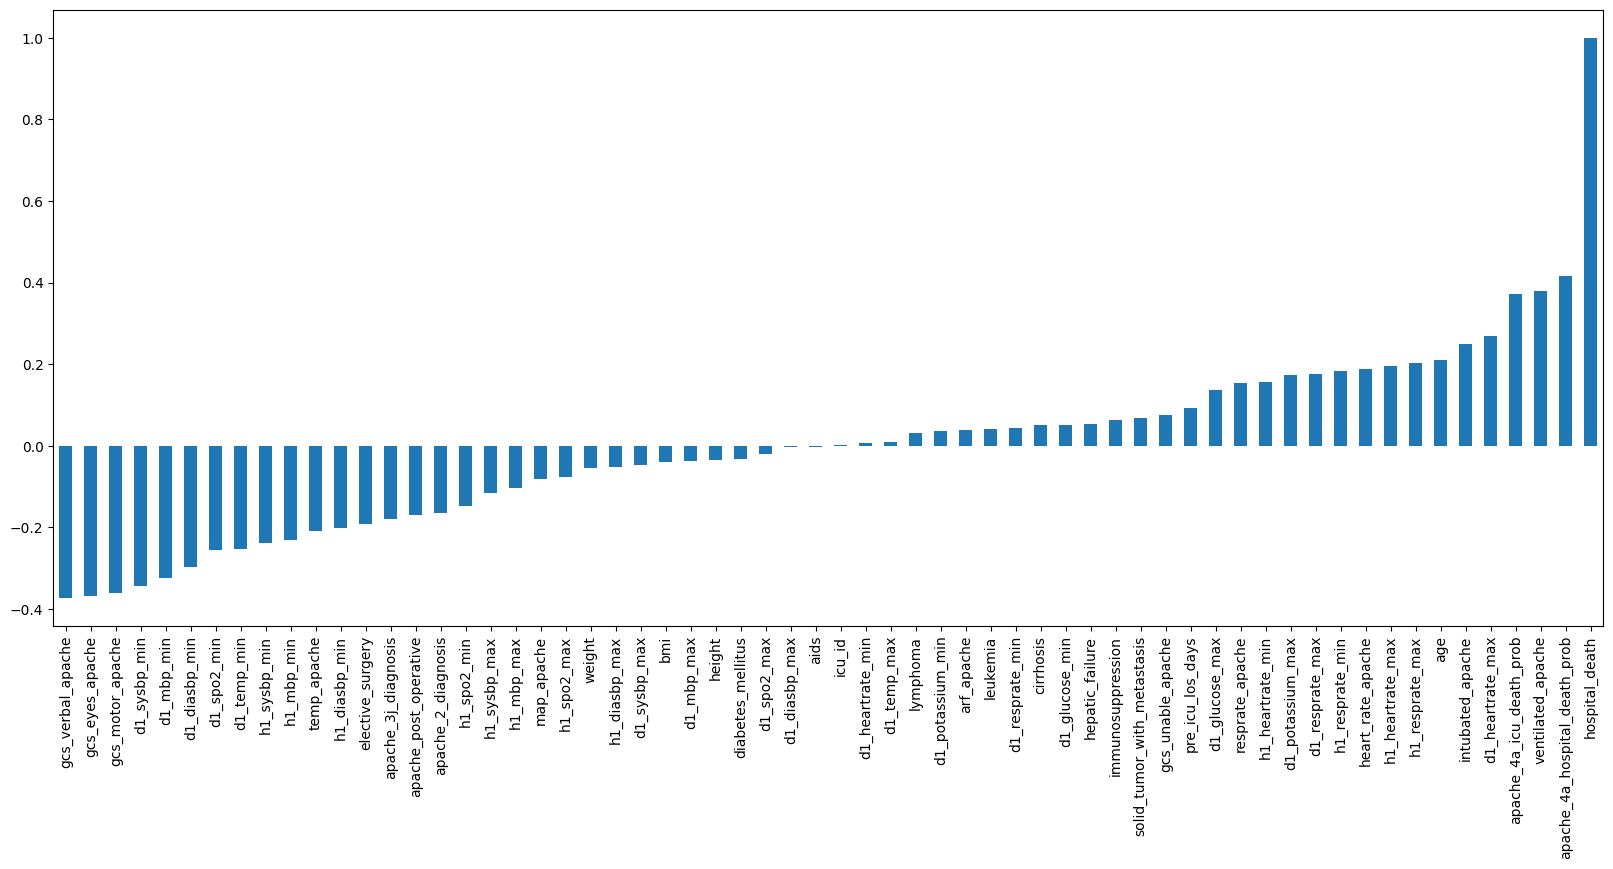

In [91]:
plt.figure(figsize=(20, 8))
data.corr()['hospital_death'].sort_values(ascending=True).plot(kind="bar")

In [92]:
corr = data.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > 0.50)]
data.drop(to_drop, axis=1, inplace=True)

C:\Users\debor\AppData\Local\Temp\ipykernel_2820\250319296.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr().abs()


In [93]:
to_drop

['weight',
 'apache_3j_diagnosis',
 'apache_post_operative',
 'gcs_motor_apache',
 'gcs_verbal_apache',
 'ventilated_apache',
 'd1_heartrate_max',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_resprate_max',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_spo2_max',
 'h1_spo2_min',
 'h1_sysbp_max',
 'h1_sysbp_min',
 'd1_potassium_min',
 'apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob',
 'hepatic_failure']

C:\Users\debor\AppData\Local\Temp\ipykernel_2820\760346063.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()['hospital_death'].sort_values(ascending=True).plot(kind="bar")


<AxesSubplot: >

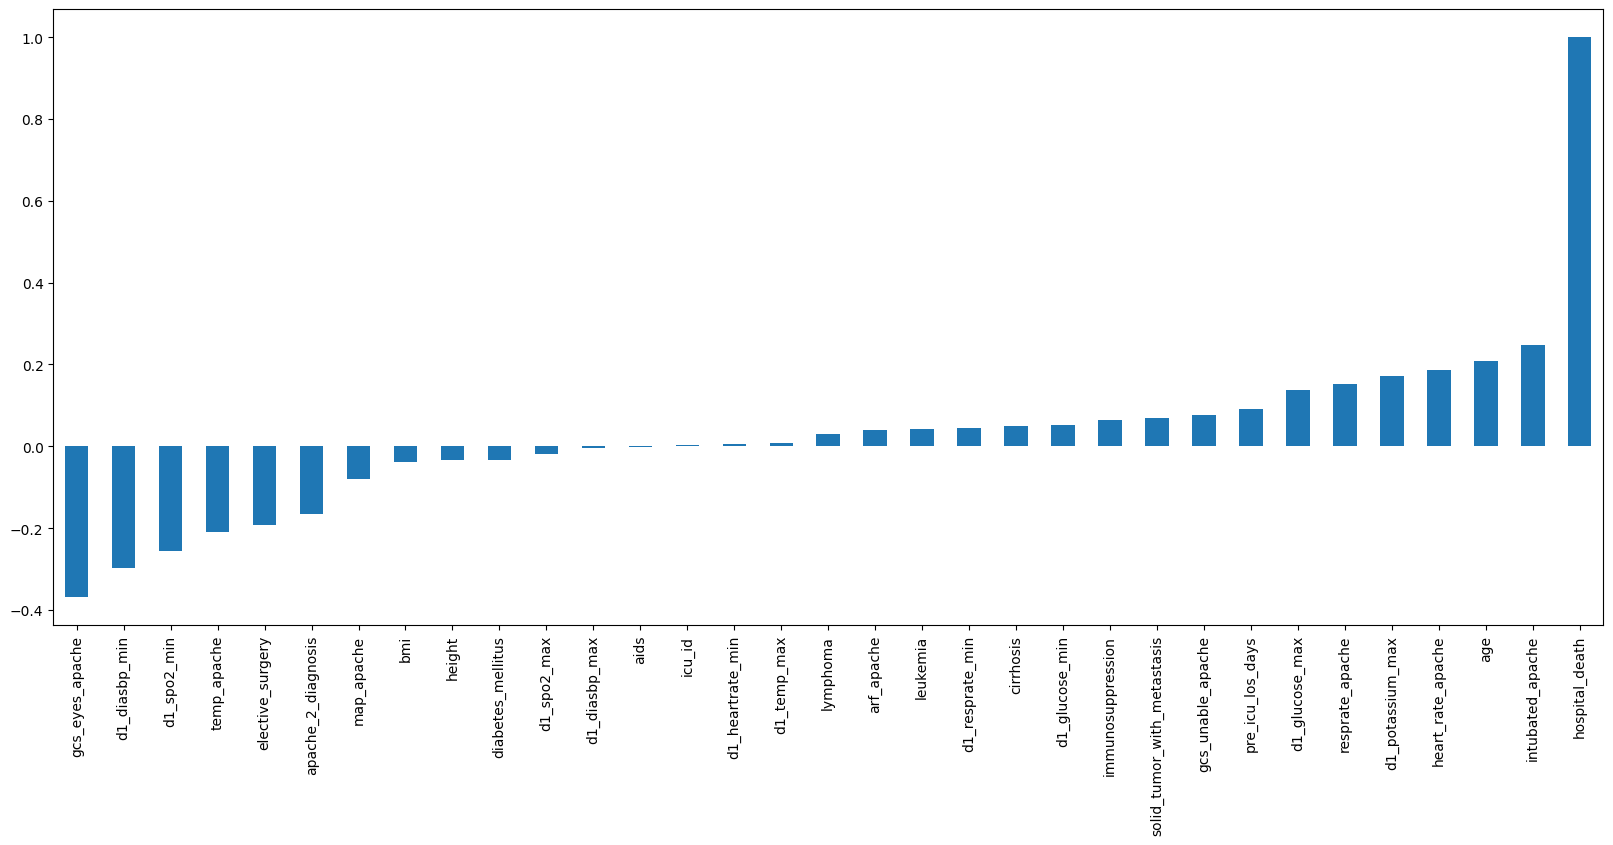

In [94]:
plt.figure(figsize=(20, 8))
data.corr()['hospital_death'].sort_values(ascending=True).plot(kind="bar")

In [95]:
corr = data.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > 0.10)]
if 'hospital_death' in to_drop:
    to_drop = to_drop.remove('hospital_death')
data.drop(to_drop, axis=1, inplace=True)

C:\Users\debor\AppData\Local\Temp\ipykernel_2820\22338403.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr().abs()


ValueError: Need to specify at least one of 'labels', 'index' or 'columns'

In [ ]:
to_drop

['bmi',
 'height',
 'pre_icu_los_days',
 'apache_2_diagnosis',
 'gcs_eyes_apache',
 'heart_rate_apache',
 'intubated_apache',
 'resprate_apache',
 'temp_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_heartrate_min',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_temp_max',
 'd1_glucose_max',
 'd1_glucose_min',
 'd1_potassium_max',
 'diabetes_mellitus',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'hospital_death']

In [ ]:
plt.figure(figsize=(20, 8))
data.corr()['hospital_death'].sort_values(ascending=True).plot(kind="bar")

C:\Users\debor\AppData\Local\Temp\ipykernel_2820\760346063.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()['hospital_death'].sort_values(ascending=True).plot(kind="bar")


KeyError: 'hospital_death'

<Figure size 2000x800 with 0 Axes>

In [ ]:
features = data.drop('hospital_death', axis=1)
labels = data['hospital_death']
features = pd.get_dummies(features)
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [ ]:
features.corr()

AttributeError: 'numpy.ndarray' object has no attribute 'corr'